# Generate DAG

## Import packages

In [59]:
import json
from collections import defaultdict
import lucid.modelzoo.vision_models as models
import numpy as np
import networkx as nx
import operator
import matplotlib.pyplot as plt

## Get general information of InceptionV1 model

In [4]:
def get_layers(graph_nodes):
    '''
    Get all layers
    * input
        - graph_nodes: tensorflow graph nodes
    * output
        - layers: list of all layers
    '''
    layers = []
    for n in graph_nodes:
        node_name = n.name
        if node_name[-2:] == '_w':
            layer = node_name.split('_')[0]
            if layer not in layers:
                layers.append(layer)
    return layers

In [5]:
def get_channel_sizes(layer, weight_nodes):
    '''
    Get channel sizes
    * input
        - layer: the name of layer
        - weight_nodes: tensorflow nodes for all filters
    * output
        - channel_sizes: list of channel size for all pre-concatenated blocks
    '''
    
    channel_sizes = [get_shape_of_node(n)[0] for n in weight_nodes if layer in n.name and '_b' == n.name[-2:] and 'bottleneck' not in n.name]
    return channel_sizes

In [6]:
def get_shape_of_node(n):
    '''
    Get the shape of the tensorflow node
    * input
        - n: tensorflow node
    * output
        - tensor_shape: shape of n
    '''
    dims = n.attr['value'].tensor.tensor_shape.dim
    tensor_shape = [d.size for d in dims]
    return tensor_shape

## Generate DAG and save it into a file

In [7]:
def load_I_matrices(all_layers, start_layer, end_layer):
    
    # Get layers starting from the given layer to the input layer
    start_idx, end_idx = all_layers.index(start_layer), all_layers.index(end_layer)
    target_layers = all_layers[start_idx: end_idx - 1: -1]

    # Load I matrices
    Is = {}
    for layer in target_layers:
        print('loading ', layer)
        Is[layer] = load_inf_matrix(I_mat_dirpath, layer)
        for branch in [1, 2]:
            inner_layer = '{}_{}'.format(layer, branch)
            Is[inner_layer] = load_inf_matrix(I_mat_dirpath, inner_layer)
            
    return Is

In [8]:
def extract_class_I_matrices(Is, all_layers, start_layer, end_layer, pred_class):

    # Get layers starting from the given layer to the input layer
    start_idx, end_idx = all_layers.index(start_layer), all_layers.index(end_layer)
    target_layers = all_layers[start_idx: end_idx - 1: -1]
    
    Is_class = {}
    
    for layer in target_layers:
        Is_class[layer] = Is[layer][pred_class]
    
    
    return Is_class

In [9]:
def generate_save_dag(Is, pred_class, I_mat_dirpath, dag_dirpath, channels, layer_fragment_sizes, dag_k=3, start_layer='mixed5b', end_layer='mixed3a'):
    '''
    Generate DAG and save it into a file
    * input
        - pred_class: predicted class
        - all_layers: all layers
        - I_mat_dirpath: directory path of I-matrices
        - dag_dirpath: direcgtory path of dag
        - channels: starting channels in start_layer (towrards output)
        - layer_fragment_sizes: sizes of fragments in all layers
        - dag_k: the number of top impactful previous channels
        - start_layer: start layer (towards output)
        - end_layer: end layer (towards input)
    * output
        - N/A
    '''

    # Get dags
    dags = gen_impactful_dags(Is, start_layer, channels, pred_class, all_layers, layer_fragment_sizes, k=dag_k, end_layer=end_layer)

    # Save dags
    filename = dag_dirpath + 'dag-{}.json'.format(pred_class)
    with open(filename, 'w') as f:
        json.dump(dags, f, indent=2)

In [10]:
def load_inf_matrix(mat_dirpath, layer):
    '''
    Load I matrix
    * input
        - mat_dirpath: directory path of I-matrices
        - layer: layer name
    * output
        - I_mat: I-matrix of the given layer
    '''
    if mat_dirpath[-1] == '/':
        filepath = mat_dirpath + 'I_' + layer + '.json'
    else:
        filepath = mat_dirpath + '/I_' + layer + '.json'
        
    with open(filepath) as f:
        I_mat = json.load(f)
    
    return I_mat

In [11]:
def gen_impactful_dags(Is, layer, channels, pred_class, all_layers, layer_fragment_sizes, k=3, end_layer='mixed3a'):
    '''
    Generate impactful dags starting from channels in a layer to input layer
    * input
        - Is: influence matrices
        - layer: starting layer
        - channels: selected channels in the layer
        - pred_class: predicted class
        - all_layers: all layers
        - layer_fragment_sizes: sizes of fragments in all layers
        - k: the number of top impactful previous channels
        - end_layer: end layer (towards input)
    * output
        - dags: a dictionary, whose
            - key: a layer
            - val: a dictionary, which maps
                - key: a neuron in current layer
                - val: list of important neurons in the previous layer
    '''
    
    # Get layers starting from the given layer to the input layer
    start_idx, end_idx = all_layers.index(layer), all_layers.index(end_layer)
    target_layers = all_layers[start_idx: end_idx - 1: -1]
    
    # Initialize the dags
    dags = {}
    
    # Record of what channels have been added to which layers
    record = {}
    
    # Aggregate the dags across layers
    curr_channels = channels[:]
    for curr_layer in target_layers:
        dags[curr_layer] = []
        record[curr_layer] = set()
        agg_prev_channels = []
        
        for curr_channel in curr_channels:
            
            # if this channel is already in the DAG, skip
            if curr_channel in record[curr_layer]:
                pass
            
            # if this channel isn't in the DAG, do the regular computation
            else:
                prev_channels, prev_infs = get_top_prevs(Is, curr_layer, curr_channel, pred_class, layer_fragment_sizes[curr_layer], k=k)
                curr_channel_dict = {'channel': curr_channel, 'prev_channels': []}
                for prev_c, prev_inf in zip(prev_channels, prev_infs):
                    curr_channel_dict['prev_channels'].append({'prev_channel': prev_c, 'inf': prev_inf})
                dags[curr_layer].append(curr_channel_dict)
                record[curr_layer].add(curr_channel)
                agg_prev_channels += prev_channels
        curr_channels = agg_prev_channels[:]
    
    return dags

In [12]:
def get_top_prevs(I_layers, layer, channel, pred_class, layer_channels, k=3):
    '''
    Get top impactful channels in previous layer
    * input
        - I_layers: a dictionary for influence matrices for the layer
            - key: layer
            - val: influence matrix of the layer
        - layer: the name of layer
        - channel: channel in the layer
        - pred_class: the predicted class
        - layer_channels: sizes of fragments in the layer
        - k: the number of top impactful previous channels
    * output
        - top_prev_channels: top k impactful previous channels
        - top_prev_infs: influences of the top k impactful previous channels
    '''
    
    # Get influences
    infs = I_layers[layer][pred_class][channel]
    
    # Get top k previous channels
    top_prev_channels = sorted(infs, key=infs.get, reverse=True)[:k]
    top_prev_infs = [infs[c] for c in top_prev_channels]
    top_prev_channels = [int(c) for c in top_prev_channels]
        
    # Figure out which branch is connected to the channel
    branch = get_branch(layer, channel, layer_channels)
    
    # If the branch goes through inner layers
    if branch in [1, 2]:
        inner_layer = '{}_{}'.format(layer, branch)
        inf_inner = I_layers[inner_layer][pred_class]
        top_infs = defaultdict(lambda: 0)
                
        for prev_channel in top_prev_channels:
            prev_infs = inf_inner[prev_channel]
            for prev_prev_channel in prev_infs.keys():
                top_infs[prev_prev_channel] += prev_infs[prev_prev_channel]
        top_prev_prev_channels = sorted(top_infs, key=top_infs.get, reverse=True)[:k]
        top_prev_prev_infs = [top_infs[c] for c in top_prev_prev_channels]
        top_prev_prev_channels = [int(c) for c in top_prev_prev_channels]
        
        return top_prev_prev_channels, top_prev_prev_infs
        
    else:
        return top_prev_channels, top_prev_infs

In [13]:
def get_branch(layer, channel, layer_channels):
    '''
    Get branch of the channel in the layer
    * input
        - layer: the name of layer
        - channel: channel in the layer
        - layer_channels: fragment sizes of the layer
    * output
        - branch: branch of the channel
    '''
    
    channels = layer_channels[:]
    for i in range(len(channels) - 1):
        channels[i + 1] += channels[i]
        
    branch = np.searchsorted(channels, channel, side='right')
    
    return branch

## RUN - Generate DAGs for all classes

In [41]:
main_dirpath = './'
M_mat_dirpath = main_dirpath + 'data/M-matrices/'
I_mat_dirpath = main_dirpath + 'data/I-matrices/'
dag_dirpath = main_dirpath + 'data/dag/'
imgnet_dirpath = main_dirpath + 'data/'

In [18]:
start_layer = 'mixed5b'
end_layer = 'mixed3a'
dag_k = 3
num_class = 1000

In [19]:
googlenet = models.InceptionV1()
googlenet.load_graphdef()
nodes = googlenet.graph_def.node

In [27]:
all_layers = get_layers(nodes)
mixed_layers = [layer for layer in all_layers if 'mixed' in layer]
layer_fragment_sizes = {layer: get_channel_sizes(layer, nodes) for layer in mixed_layers}

In [21]:
with open(imgnet_dirpath + 'imagenet.json') as f:
    imgnet = json.load(f)

In [22]:
Is = load_I_matrices(all_layers, start_layer, end_layer)

loading  mixed5b
loading  mixed5a
loading  mixed4e
loading  mixed4d
loading  mixed4c
loading  mixed4b
loading  mixed4a
loading  mixed3b
loading  mixed3a


In [28]:
pred_class = 0
Is_class = extract_class_I_matrices(Is, all_layers, start_layer, end_layer, pred_class)

In [34]:
len(Is_class['mixed5a'])

832

In [35]:
G = nx.Graph()

for layer_idx, layer in enumerate(mixed_layers[::-1]):
    if layer == 'mixed3a':
        pass
    else:
        for i, channel in enumerate(Is_class[layer]):
            src = layer + '-' + str(i)
            for prev_channel in channel:
                tgt =  mixed_layers[::-1][layer_idx+1] + '-' + str(prev_channel)
                G.add_edge(src, tgt)

In [36]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 5483\nNumber of edges: 245700\nAverage degree:  89.6225'

In [45]:
personalization = {node: 1 for node in list(G.nodes)}

for layer in mixed_layers[::-1]:
    M = np.loadtxt(M_mat_dirpath + 'M-' + layer + '.csv', delimiter=',', dtype=int)
    for channel in range(M.shape[-1]):
        node = layer + '-' + str(channel)
        if node in personalization:
            personalization[layer + '-' + str(channel)] = M[pred_class][channel]    

In [48]:
pagerank = nx.pagerank(G, personalization=personalization)

In [54]:
# sorted_x = sorted(pagerank.items(), key=operator.itemgetter(1), reverse=True)

In [57]:
pageranks_per_layer = {}
for layer in mixed_layers[::-1]:
    pageranks_per_layer[layer] = []
    
for node in pagerank:
    layer = node.split('-')[0]
    pageranks_per_layer[layer].append(pagerank[node])

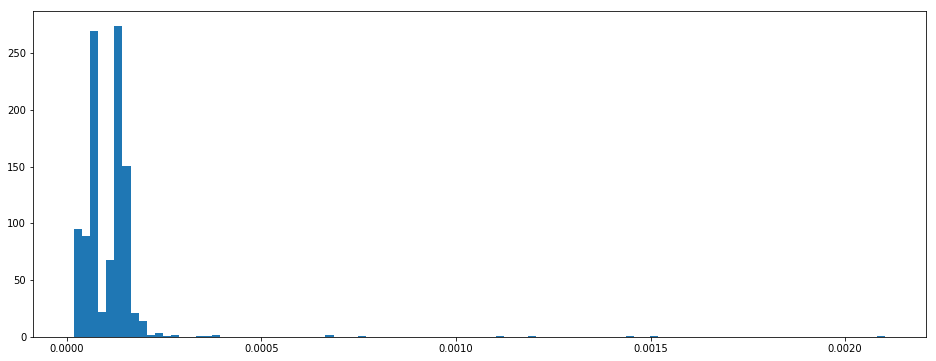

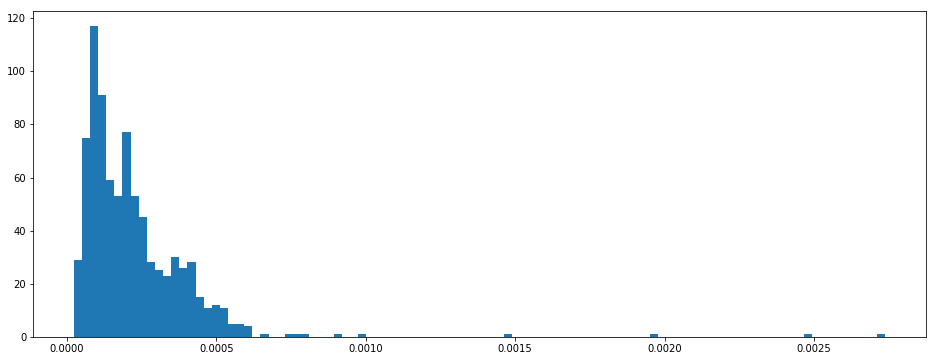

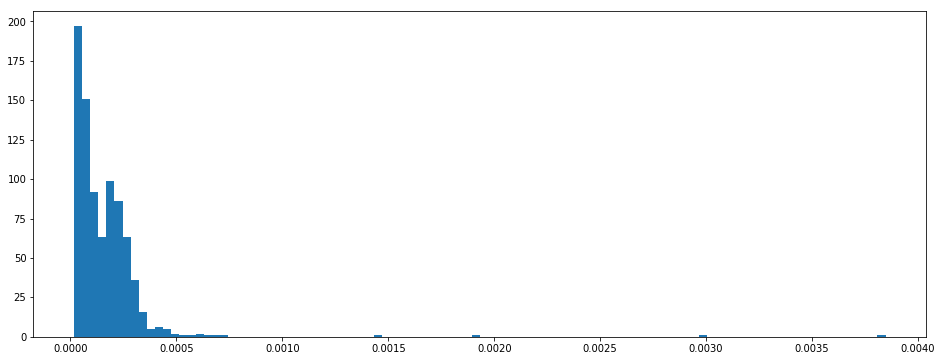

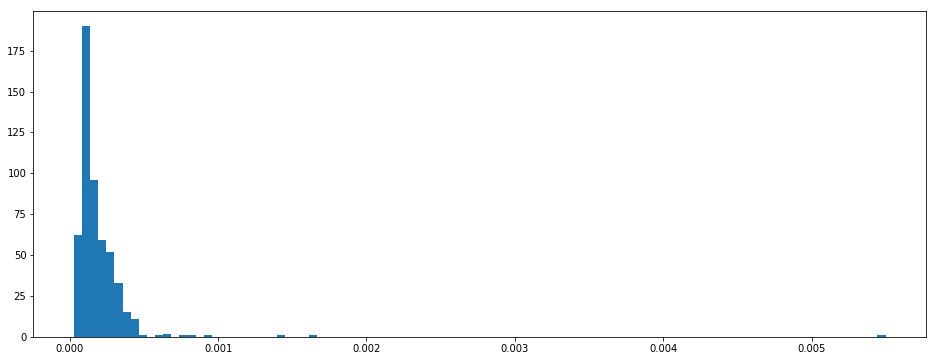

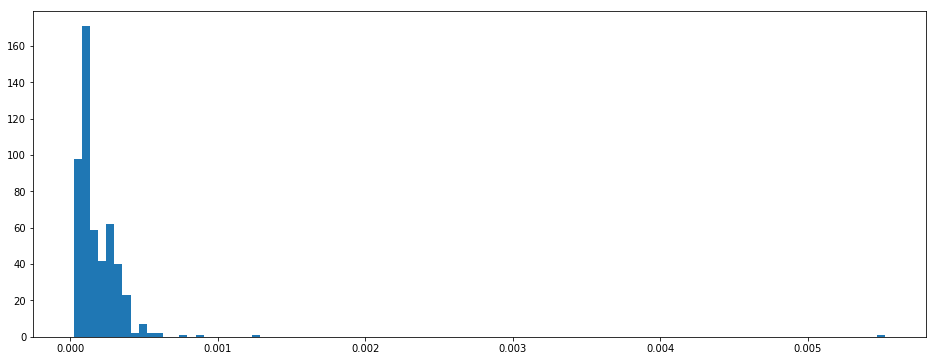

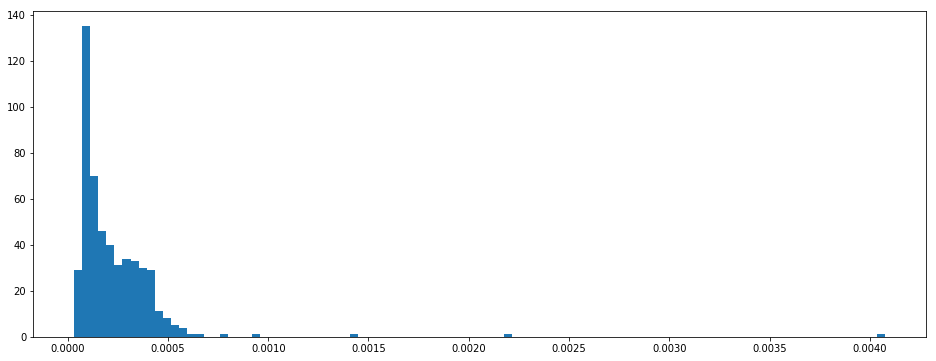

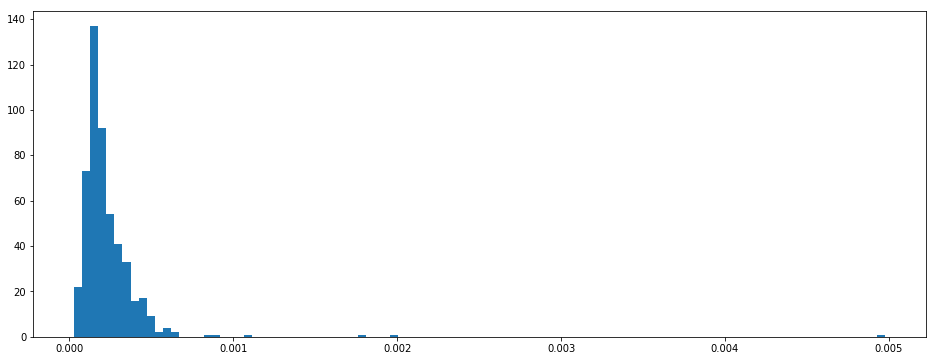

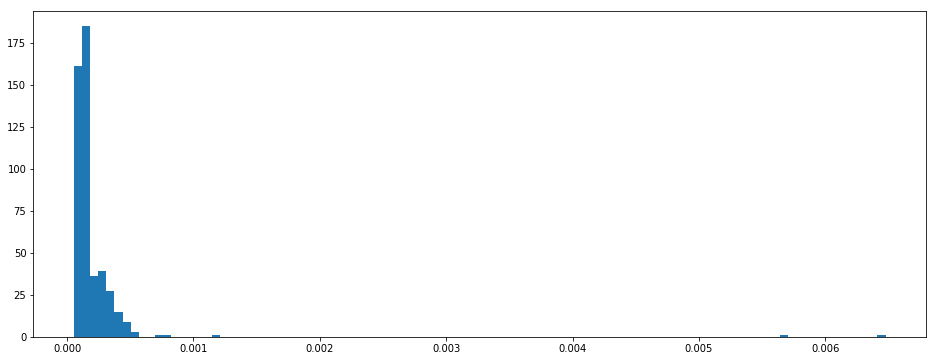

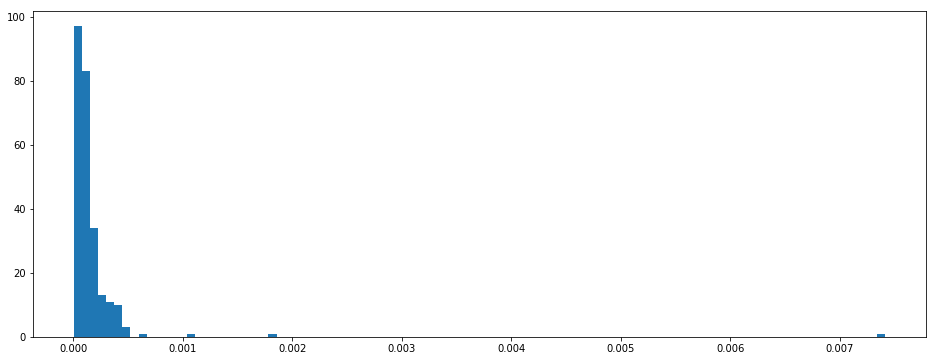

In [64]:
for layer in mixed_layers[::-1]:
    plt.figure(figsize=(16,6))
    plt.hist(pageranks_per_layer[layer], bins=100)
    plt.show()

In [33]:
for th in range(num_class):
    
    if th % 100 == 0:
        print(th)
    
    pred_class = imgnet[th]['target_class']
    prev_counter = imgnet[th]['topChannels'][start_layer]
    channels = [prev_counter[i]['channel'] for i in range(dag_k)]    
    generate_save_dag(Is, pred_class, I_mat_dirpath, dag_dirpath, channels, layer_fragment_sizes, 3, start_layer, end_layer)

0
100
200
300
400
500
600
700
800
900


## Test examples

In [52]:
# kit fox, mixed5b
# pred_class = 278
# channels = [765,186,270]

# white wolf, mixed4c
# pred_class = 270
# channels = [264,216]

# white wolf, mixed5b
# pred_class = 270
# channels = [821,101,116]

# fire engine, mixed5b
# pred_class = 555
# channels = [876,881,661]

# # fire engine, mixed5a
# pred_class = 555
# channels = [581,432,586]

# strawberry, mixed5a, tfr1
# pred_class = 949
# channels = [306,504,20]

# generate_save_dag(pred_class, all_layers, I_mat_dirpath, dag_dirpath, channels, layer_fragment_sizes, 3, 'mixed5b', 'mixed4b')